In [1]:
#imports and formatting
#libraries to import
import requests
import os
import pandas as pd
import json
import time
import numpy as np
import datetime
pd.set_option('display.max_columns', None)
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
#import dataframes 
#inspect dfs
#merge and clean duplicates, nulls etc 

In [3]:
#import API data and scraped data for US and Canadian markets
US_data = pd.read_csv(f"{os.path.abspath('../data/top500_companies_US.csv')}")
CAN_data =  pd.read_csv(f"{os.path.abspath('../data/top500_companies_canada.csv')}")

In [4]:
#inspect dfs, check for nulls, check for dupes and drop
# check data types are proper and change if needed


Clean US data from Polygon API

In [5]:
#check for nulls for US Market Data 
US_data.isnull().sum()


Date                  2
Company Name          0
Ticker Symbol         0
Oct2023 Market Cap    0
Open                  2
Low                   2
High                  2
Close                 2
Volume                2
dtype: int64

In [6]:
#further inspect missing data
missing_USdata = US_data[US_data['Date'].isnull()] , [US_data['Open'].isnull()] , [US_data['Low'].isnull()] , [US_data['High'].isnull()] , [US_data['Close'].isnull()], [US_data['Volume'].isnull()]
missing_USdata

(       Date         Company Name Ticker Symbol Oct2023 Market Cap  Open  Low  \
 2922    NaN  Berkshire Hathaway          BRK-B          $744.39 B   NaN  NaN   
 132599  NaN         Brown Forman          BF-A           $27.13 B   NaN  NaN   
 
         High  Close  Volume  
 2922     NaN    NaN     NaN  
 132599   NaN    NaN     NaN  ,
 [0         False
  1         False
  2         False
  3         False
  4         False
            ...  
  247626    False
  247627    False
  247628    False
  247629    False
  247630    False
  Name: Open, Length: 247631, dtype: bool],
 [0         False
  1         False
  2         False
  3         False
  4         False
            ...  
  247626    False
  247627    False
  247628    False
  247629    False
  247630    False
  Name: Low, Length: 247631, dtype: bool],
 [0         False
  1         False
  2         False
  3         False
  4         False
            ...  
  247626    False
  247627    False
  247628    False
  247629    Fals

In [7]:
#get the surrounding data for the missing data to give context and help drive data cleaning decision to impute the data or remove
for index in [2922, 132599]:
    display(US_data.iloc[index-3:index+4])

,Date,Company Name,Ticker Symbol,Oct2023 Market Cap,Open,Low,High,Close,Volume
2919,2023-10-26,Meta Platforms (Facebook),META,$774.22 B,295.0000,279.4030,295.0000,288.3500,66684141.0
2920,2023-10-27,Meta Platforms (Facebook),META,$774.22 B,294.4800,292.9700,299.3100,296.7300,29596256.0
2921,2023-10-30,Meta Platforms (Facebook),META,$774.22 B,299.0900,299.0500,309.3967,302.6600,28435055.0
2922,NaN,Berkshire Hathaway,BRK-B,$744.39 B,NaN,NaN,NaN,NaN,NaN
2923,2021-11-01,Tesla,TSLA,$638.45 B,381.6667,372.8867,403.2500,402.8633,168128235.0
2924,2021-11-02,Tesla,TSLA,$638.45 B,386.4517,382.0000,402.8633,390.6667,128135646.0
2925,2021-11-03,Tesla,TSLA,$638.45 B,392.4433,384.2067,405.1300,404.6200,103877037.0


,Date,Company Name,Ticker Symbol,Oct2023 Market Cap,Open,Low,High,Close,Volume
132596,2023-10-26,GlobalFoundries,GFS,$27.42 B,51.54,51.5400,53.0700,52.06,1222979.0
132597,2023-10-27,GlobalFoundries,GFS,$27.42 B,52.41,51.7200,52.7400,51.98,702067.0
132598,2023-10-30,GlobalFoundries,GFS,$27.42 B,51.98,49.7100,52.0000,49.91,1640764.0
132599,NaN,Brown Forman,BF-A,$27.13 B,NaN,NaN,NaN,NaN,NaN
132600,2021-11-01,Cheniere Energy\n,CQP,$26.98 B,43.94,43.6450,44.5066,44.10,159016.0
132601,2021-11-02,Cheniere Energy\n,CQP,$26.98 B,44.23,42.7500,44.2300,43.71,195260.0
132602,2021-11-03,Cheniere Energy\n,CQP,$26.98 B,43.97,42.4301,43.9700,43.59,231537.0


In [8]:
#after inspection I realized that the missing dates for both stocks is 2023 Oct 31, this API data was pulled on that same date and may result in the NaN values, for the purpose of the analysis it is okay to remove it as it will not skew data, we will just have a slightly smaller data set to work with. 
#the missing data does not suggest continuity as that is that last date in the API call parameter and will not skew data if excluded
# remove the NaN rows, then reset index for proper continuity

US_data_cleaned = US_data.dropna(subset= ['Date', 'Open', 'Close', 'High', 'Low', 'Volume'])

US_data_cleaned.reset_index(drop=True, inplace=True)

#QA check                         
print(US_data_cleaned.isnull().sum())

#passed 

Date                  0
Company Name          0
Ticker Symbol         0
Oct2023 Market Cap    0
Open                  0
Low                   0
High                  0
Close                 0
Volume                0
dtype: int64


In [9]:
#Check for duplicate rows 
US_data_cleaned.duplicated().sum()

0

In [10]:
#verify and optimize data types for EDA
print(US_data_cleaned.dtypes)
US_data_cleaned.head()

Date                   object
Company Name           object
Ticker Symbol          object
Oct2023 Market Cap     object
Open                  float64
Low                   float64
High                  float64
Close                 float64
Volume                float64
dtype: object


,Date,Company Name,Ticker Symbol,Oct2023 Market Cap,Open,Low,High,Close,Volume
0,2021-11-01,Apple,AAPL,$2.669 T,148.985,147.80,149.70,148.96,74588257.0
1,2021-11-02,Apple,AAPL,$2.669 T,148.660,148.65,151.57,150.02,69121986.0
2,2021-11-03,Apple,AAPL,$2.669 T,150.390,149.82,151.97,151.49,54511532.0
3,2021-11-04,Apple,AAPL,$2.669 T,151.580,150.64,152.43,150.96,60394613.0
4,2021-11-05,Apple,AAPL,$2.669 T,151.890,150.06,152.20,151.28,65163883.0


In [11]:
#convert date to datetime data type, convert market cap to float dtype
US_data_cleaned['Date'] = pd.to_datetime(US_data_cleaned['Date'])


#to convert market cap i need to account for million billion and trillion valuations and convert accordingly 
def convert_market_cap(valuation):
    valuation = valuation.replace('$', '').replace(',', '')
    
    #check for Million or Billion or Trillion valuation and convert to float based on dollar value
    if 'M' in valuation:
        return float(valuation.replace('M','')) * 1e6 #multiply by digits in million 
    elif 'B' in  valuation:
        return float(valuation.replace('B','')) * 1e9 #multiple by digits in billion 
    elif 'T' in valuation:
        return float(valuation.replace('T','')) * 1e12 # multiply by digits in trillion 
    else:
        return float(valuation)

US_data_cleaned['Oct2023 Market Cap'] = US_data_cleaned['Oct2023 Market Cap'].apply(convert_market_cap)


#QA check 
US_data_cleaned.dtypes
#passed 


C:\Users\mario\AppData\Local\Temp\ipykernel_27728\2918158057.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_data_cleaned['Date'] = pd.to_datetime(US_data_cleaned['Date'])
C:\Users\mario\AppData\Local\Temp\ipykernel_27728\2918158057.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_data_cleaned['Oct2023 Market Cap'] = US_data_cleaned['Oct2023 Market Cap'].apply(convert_market_cap)


Date                  datetime64[ns]
Company Name                  object
Ticker Symbol                 object
Oct2023 Market Cap           float64
Open                         float64
Low                          float64
High                         float64
Close                        float64
Volume                       float64
dtype: object

EDA for US Market Data 

Q1 How big is the data frame in terms of columns and rows but also memory 

In [12]:
#Get number of rows and columns of the data frame of all the stocks 
rows, columns = US_data_cleaned.shape
print (f'rows: {rows}')
print (f'columns: {columns}')

#code how much memory it takes to run the df, divide by 1024 sqaured sinces to get megabytes 
memory_usage_inMB = US_data_cleaned.memory_usage(deep=True).sum() / (1024*1024)


print(('Memory: '), memory_usage_inMB,('mb'))

rows: 247629
columns: 9
Memory:  44.011566162109375 mb


Q2 What are the 5 most volatile stocks (measure using avg daily percent change over last 2 years)

In [13]:
#rough notes 
# calculate daily percent change for each stock 
#filter out for the last 2 years 
#group by ticker symbol and calcular avg daily percent changes 
#sort data to find top 5 stocks with the highest avg daily percent changes 
#plot using seaborn 


In [14]:
US_data_cleaned['Daily Percent Change'] = US_data_cleaned.groupby('Company Name')['Close'].pct_change() * 100

C:\Users\mario\AppData\Local\Temp\ipykernel_27728\2649470306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_data_cleaned['Daily Percent Change'] = US_data_cleaned.groupby('Company Name')['Close'].pct_change() * 100


In [15]:
#filter data so i only get rows from the past 2 years 
latest_date = US_data_cleaned['Date'].max()
two_yearsago = latest_date - pd.Timedelta(days=730)
filtered_US_data = US_data_cleaned[US_data_cleaned['Date']> two_yearsago]

filtered_US_data

,Date,Company Name,Ticker Symbol,Oct2023 Market Cap,Open,Low,High,Close,Volume,Daily Percent Change
0,2021-11-01,Apple,AAPL,2.669000e+12,148.985,147.800,149.700,148.96,74588257.0,NaN
1,2021-11-02,Apple,AAPL,2.669000e+12,148.660,148.650,151.570,150.02,69121986.0,0.711600
2,2021-11-03,Apple,AAPL,2.669000e+12,150.390,149.820,151.970,151.49,54511532.0,0.979869
3,2021-11-04,Apple,AAPL,2.669000e+12,151.580,150.640,152.430,150.96,60394613.0,-0.349858
4,2021-11-05,Apple,AAPL,2.669000e+12,151.890,150.060,152.200,151.28,65163883.0,0.211977
...,...,...,...,...,...,...,...,...,...,...
247624,2023-10-24,AspenTech,AZPN,1.133000e+10,179.000,178.625,181.740,179.40,136873.0,0.402955
247625,2023-10-25,AspenTech,AZPN,1.133000e+10,178.010,176.395,180.155,176.87,82594.0,-1.410256
247626,2023-10-26,AspenTech,AZPN,1.133000e+10,177.190,176.060,180.280,180.00,156481.0,1.769661
247627,2023-10-27,AspenTech,AZPN,1.133000e+10,179.460,177.560,180.220,178.49,166534.0,-0.838889


In [16]:
#calculate volatility by getting the average daily percent change using the filtered date from above 
volatilty = filtered_US_data.groupby('Company Name')['Daily Percent Change'].mean()


In [17]:
#sort stocks and get top 5 stocks with highest average daily percent changes (volatility)
top5_volatile_stocks = volatilty.sort_values(ascending=False).head(5)

top5_volatile_stocks

Company Name
Meta Platforms (Facebook)    3.506250
Supermicro                   0.467459
Symbotic                     0.411269
Constellation Energy         0.201680
Celsius Holdings\n           0.195889
Name: Daily Percent Change, dtype: float64

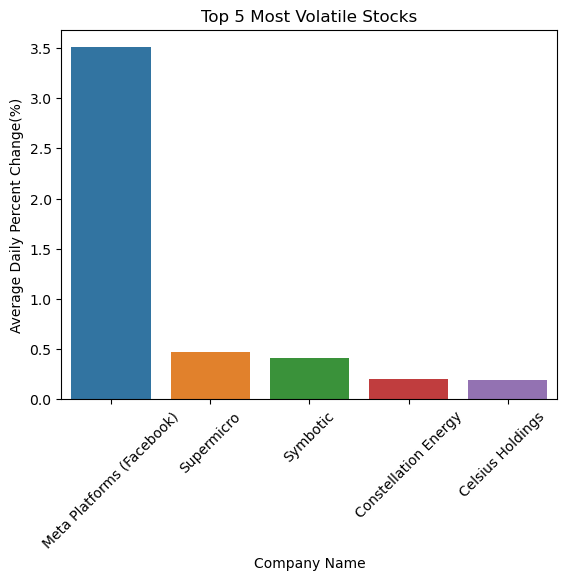

In [18]:
#plot the 5 winners and compare 
sns.barplot(x=top5_volatile_stocks.index, y=top5_volatile_stocks.values)
plt.title('Top 5 Most Volatile Stocks')
plt.ylabel('Average Daily Percent Change(%)')
plt.xticks(rotation=45)
plt.show()


Q3 Compare the Market Cap trend for TSLA (tesla) and T (AT&T) which had more growth based on price?


In [19]:
#rough notes 
#filter the two stocks data for the last 2 years 
#calculate market cap group each month for each stock
#plot on line graph

In [20]:
#filter the two stocks data for the last 2 years (oct 2023 - nov 2021)

#define dates to use
start_date = '2021-11-01'
end_date = '2023-10-30'
#filter for tsla and T
tsla_data = US_data_cleaned[(US_data_cleaned['Ticker Symbol']== 'TSLA') & (US_data_cleaned['Date']>= start_date) & (US_data_cleaned['Date']<= end_date)]
t_data = US_data_cleaned[(US_data_cleaned['Ticker Symbol']== 'T') & (US_data_cleaned['Date']>= start_date) & (US_data_cleaned['Date']<= end_date)]


In [21]:
#calculate price growth per day for the last 2 years 
tsla_data['Price Growth'] = (tsla_data['Close'] - tsla_data['Close'].iloc[0]) / tsla_data['Close'].iloc[0]
t_data['Price Growth'] = (t_data['Close'] - t_data['Close'].iloc[0]) / t_data['Close'].iloc[0]

#print the final growth percentage and compare answers for Tsla and T 
totalgrowth_tsla = tsla_data['Price Growth'].iloc[-1]
totalgrowth_t = t_data['Price Growth'].iloc[-1]

print(f'TSLA Growth: {totalgrowth_tsla * 100:.2f}%') 
print(f'T Growth: {totalgrowth_t * 100:.2f}%') 


TSLA Growth: -51.01%
T Growth: -39.85%


C:\Users\mario\AppData\Local\Temp\ipykernel_27728\2434755991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_data['Price Growth'] = (tsla_data['Close'] - tsla_data['Close'].iloc[0]) / tsla_data['Close'].iloc[0]
C:\Users\mario\AppData\Local\Temp\ipykernel_27728\2434755991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_data['Price Growth'] = (t_data['Close'] - t_data['Close'].iloc[0]) / t_data['Close'].iloc[0]


C:\Users\mario\AppData\Local\Temp\ipykernel_27728\167034857.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= tsla_data, x='Date', y='Price Growth', label= 'TSLA', ci=None)
C:\Users\mario\AppData\Local\Temp\ipykernel_27728\167034857.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data= t_data, x='Date', y='Price Growth', label= 'T', ci=None)


<function matplotlib.pyplot.show(close=None, block=None)>

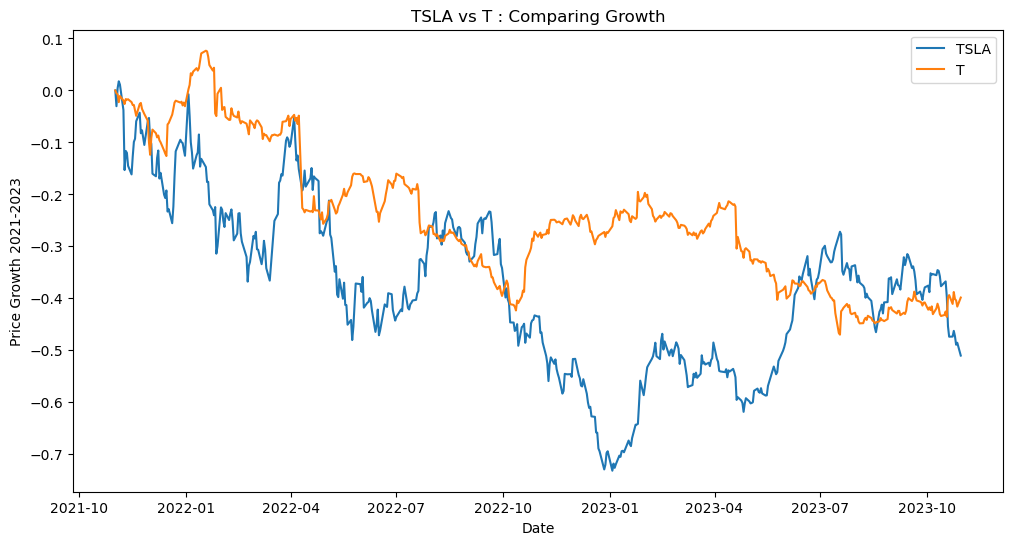

In [22]:
#plot the results 
plt.figure(figsize=(12, 6))
sns.lineplot(data= tsla_data, x='Date', y='Price Growth', label= 'TSLA', ci=None)
sns.lineplot(data= t_data, x='Date', y='Price Growth', label= 'T', ci=None)
plt.title("TSLA vs T : Comparing Growth")
plt.ylabel('Price Growth 2021-2023')
plt.xlabel('Date')
plt.legend()
plt.show

Q4 Which 5 Stocks had the lowest return in the last 2 years 

In [23]:
#use previously date filtered data 'start_date' and 'end_date'  
# find out the initial price 2 years ago 
startprice = US_data_cleaned[US_data_cleaned['Date'] == start_date].set_index('Ticker Symbol')['Close']
endprice = US_data_cleaned[US_data_cleaned['Date'] == end_date].set_index('Ticker Symbol')['Close']


In [24]:
#calculate percent change of price from nov 2021 to oct 2023
price_change = ((endprice - startprice) / startprice) * 100 


In [25]:
# select the bottom 5 values from price change func
five_worst_performers = price_change.nsmallest(5)

print(five_worst_performers)

Ticker Symbol
SQ     -84.622020
SNAP   -82.030382
ZM     -78.489998
MRNA   -78.031853
PYPL   -77.927188
Name: Close, dtype: float64


In [26]:
#export filtered_US_data to CVS for further processing
filtered_US_data.to_csv(f"{os.path.abspath('../data/filtered_US_data.csv')}", index=False) 

Logistic Modelling For Stock Trades 

In [27]:
#rough notes 
#to build logistic model that predicts next day stock price to go up (1) or otherwise(0)
#this is built on predictor variables and target variables and may be inaccurate or may produce unmeaningful results 

#create binary target variable
#prep data for model 
#build model 
#run tests to see if model is accurate 
#See the results 

In [28]:
#create binary target variable


US_data_cleaned['Next Day Close'] = US_data_cleaned['Close'].shift(-1)
US_data_cleaned['Price up'] = US_data_cleaned.apply(lambda row: 1 if row['Next Day Close']> row['Close'] else 0, axis=1)



C:\Users\mario\AppData\Local\Temp\ipykernel_27728\1498919467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_data_cleaned['Next Day Close'] = US_data_cleaned['Close'].shift(-1)
C:\Users\mario\AppData\Local\Temp\ipykernel_27728\1498919467.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  US_data_cleaned['Price up'] = US_data_cleaned.apply(lambda row: 1 if row['Next Day Close']> row['Close'] else 0, axis=1)


In [29]:
#set x and y and prepare data 
X = US_data_cleaned[['Open', 'Low', 'High', 'Volume']]
y = US_data_cleaned['Price up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



In [30]:
#build model 
pricepredictor_model = LogisticRegression()
pricepredictor_model.fit(X_train, y_train)



LogisticRegression()

In [31]:
price_prediction = pricepredictor_model.predict(X_test)
model_accuracy = accuracy_score(y_test, price_prediction)
model_accuracy

0.4962847797116666

In [32]:
model_coefficients = pricepredictor_model.coef_
model_coefficients

array([[ 1.7527733e-14,  1.7837926e-14,  1.8288747e-14, -6.6997170e-10]])

In [33]:
#model interpretations 
#based on accuracy score and coefficients being extremely small, the model tells us that the open, close, high and low of a the previous
#days stock has very little to do on how the stock will do the next day.
#this is likely due to our very barebones data set and simplistic modelling , but also the nature of the stock market as it is truly 
#impossible to predict it with 100 percent accuracy. 